In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance.plotting as mpf
import seaborn as sns
import datetime
import re
import ccxt
import pickle
# pd.options.plotting.backend = "plotly"

In [2]:
df = pd.read_csv('dataset/cryptdownload/Binance_ETHUSDT_1h.csv')
df['time'] = pd.to_datetime(df['time'])
df.sort_values('time', ascending=True, inplace=True)
df.drop(columns=['symbol', 'tradecount'], inplace=True)
df

,time,base_volume,quote_volume,close,high,low,open
32620,2017-08-17 04:00:00,122.52000,3.673684e+04,300.79,652.74,298.00,652.74
32619,2017-08-17 05:00:00,377.67000,1.140433e+05,303.10,303.28,300.00,301.61
32618,2017-08-17 06:00:00,302.51000,9.162268e+04,302.68,304.44,301.90,303.10
32617,2017-08-17 07:00:00,753.19000,2.292483e+05,307.96,307.96,302.60,302.68
32616,2017-08-17 08:00:00,150.75000,4.655946e+04,308.62,309.97,307.00,307.96
...,...,...,...,...,...,...,...
4,2021-05-07 20:00:00,18632.39404,6.533341e+07,3497.20,3525.62,3476.04,3512.59
3,2021-05-07 21:00:00,21439.49414,7.456822e+07,3475.89,3497.80,3455.70,3497.17
2,2021-05-07 22:00:00,38829.22486,1.340210e+08,3443.00,3499.00,3421.11,3475.83
1,2021-05-07 23:00:00,19900.24004,6.908357e+07,3479.53,3489.00,3438.59,3442.19


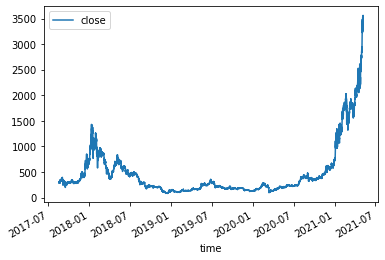

In [3]:
df.plot(x='time', y='close')

# Feature engineering

In [4]:
ORIGINAL_SIGNAL_COLUMNS = ['open', 'high', 'low', 'close']

## Create target column

In [5]:
target_column = 'close'
shifting_df = df[['time', 'close']].copy()
shifting_df['time'] = shifting_df['time'] - pd.Timedelta(hours=1)

last_datetime = df['time'].max() - pd.Timedelta(hours=1)
df = df[df['time'] <= last_datetime]

shifting_df.rename(columns={'close': 'next_close'}, inplace=True)
df = df.merge(shifting_df, how='left', on='time')

## Drop nan target 

In [6]:
df.isna().sum(axis=0)

time            0
base_volume     0
quote_volume    1
close           0
high            0
low             0
open            0
next_close      8
dtype: int64

In [7]:

df.dropna(subset=['next_close'], inplace=True)
df.isna().sum(axis=0)

time            0
base_volume     0
quote_volume    1
close           0
high            0
low             0
open            0
next_close      0
dtype: int64

## Add Techinal Indicator

## Generate past signal data

In [10]:
def generate_past_signal_data(df, lookback_steps):
    
    base_df = df[['time'] + ORIGINAL_SIGNAL_COLUMNS]
    
    first_datetime = df['time'].min() + pd.Timedelta(hours=max(lookback_steps))
    df = df[df['time'] >= first_datetime]
    for lookback_step in lookback_steps:
        shifting_df = base_df.copy()
        shifting_df['time'] = shifting_df['time'] + pd.Timedelta(hours=lookback_step)
        lookback_columns = [f'p{lookback_step}_{col}' for col in ORIGINAL_SIGNAL_COLUMNS]
        shifting_df.rename(columns=dict(zip(ORIGINAL_SIGNAL_COLUMNS, lookback_columns)), inplace=True)
        
        df = df.merge(shifting_df, how='left', on='time')
    return df

# lookback_steps = [0, 1, 2, 3, 4]
lookback_steps = np.arange(48)
df = generate_past_signal_data(df, lookback_steps)
df.set_index('time', inplace=True)

KeyError: "['time'] not in index"

In [ ]:
def get_by_lookback_step(df, lookback_step):
    return df.filter(regex=f'p{lookback_step}_')
def get_by_lookback_steps(df, lookback_steps):
    lookback_steps = list(map(str, lookback_steps))
    return df.filter(regex=f'p({"|".join(lookback_steps)})_')
def get_by_signal(df, signal_column):
    return df.filter(regex=f'p\d+_{signal_column}')
def get_only_signal(df):
    return df.filter(regex=f'p\d+_.')
# get_by_lookback_step(df, 1)
# get_by_signal(df, 'close')
get_only_signal(df)

## Normalize signal data

### Min-Max Close of Individual window

In [11]:
class MinMaxCloseWindowScaler:
    def fit(self, signal_df):
        self.min_close = get_by_signal(signal_df, 'close').min(axis=1)
        self.max_close = get_by_signal(signal_df, 'close').max(axis=1)
    def transform(self, signal_df):
        signal_df = signal_df.subtract(self.min_close, axis=0).div(self.max_close - self.min_close, axis=0)
        return signal_df
    def fit_transform(self, signal_df):
        self.fit(signal_df)
        return self.transform(signal_df)
    def transform_target(self, target):
        return (target - self.min_close) / (self.max_close - self.min_close)
    def inverse_transform_target(self, target):
        return target * (self.max_close - self.min_close) + self.min_close


In [12]:
_df = df.copy()
signal_df = get_only_signal(_df)

min_max_close_window_scaler = MinMaxCloseWindowScaler()
_df[signal_df.columns] = min_max_close_window_scaler.fit_transform(signal_df)
_df['norm_next_close'] = min_max_close_window_scaler.transform_target(_df['next_close'])
_df

,base_volume,quote_volume,close,high,low,open,next_close,p0_open,p0_high,p0_low,...,p45_close,p46_open,p46_high,p46_low,p46_close,p47_open,p47_high,p47_low,p47_close,norm_next_close
time,,,,,,,,,,,,,,,,,,,,,
2017-08-19 03:00:00,66.65000,1.964252e+04,293.22,299.84,292.83,299.84,291.87,0.571308,0.571308,0.275527,...,0.691139,0.645992,0.716456,0.578059,0.708861,15.461603,15.461603,0.493671,0.611392,0.235021
2017-08-19 04:00:00,42.99000,1.263183e+04,291.87,297.19,291.87,293.22,293.23,0.291983,0.459494,0.235021,...,0.913924,0.708861,0.765401,0.658228,0.691139,0.645992,0.716456,0.578059,0.708861,0.292405
2017-08-19 05:00:00,35.01000,1.040870e+04,293.23,299.90,291.87,291.87,289.02,0.235021,0.573840,0.235021,...,0.941772,0.691139,0.913924,0.687764,0.913924,0.708861,0.765401,0.658228,0.691139,0.114768
2017-08-19 06:00:00,45.02000,1.316110e+04,289.02,295.56,289.02,293.23,290.16,0.292405,0.390717,0.114768,...,1.000000,0.913924,0.998734,0.873418,0.941772,0.691139,0.913924,0.687764,0.913924,0.162869
2017-08-19 07:00:00,112.26000,3.248597e+04,290.16,292.17,287.01,289.02,288.40,0.114768,0.247679,0.029958,...,0.970464,0.941772,1.084388,0.941772,1.000000,0.913924,0.998734,0.873418,0.941772,0.088608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 19:00:00,22844.22755,8.026408e+07,3512.59,3533.76,3498.28,3525.90,3497.20,0.791414,0.838216,0.626950,...,0.764618,0.393414,0.436644,0.160831,0.198702,0.521079,0.547160,0.114684,0.394962,0.620519
2021-05-07 20:00:00,18632.39404,6.533341e+07,3497.20,3525.62,3476.04,3512.59,3475.89,0.712159,0.789746,0.494522,...,0.781648,0.198702,0.858283,0.196677,0.764618,0.393414,0.436644,0.160831,0.198702,0.493629
2021-05-07 21:00:00,21439.49414,7.456822e+07,3475.89,3497.80,3455.70,3497.17,3443.00,0.620341,0.624092,0.373407,...,0.492200,0.762415,0.930987,0.602001,0.781648,0.198702,0.858283,0.196677,0.764618,0.297785


/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


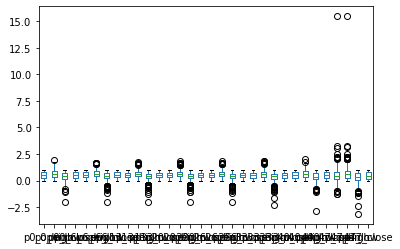

In [13]:
sampled_lookback_steps = np.linspace(0, max(lookback_steps), 8).astype(int)

get_by_lookback_steps(_df, sampled_lookback_steps).plot.box()

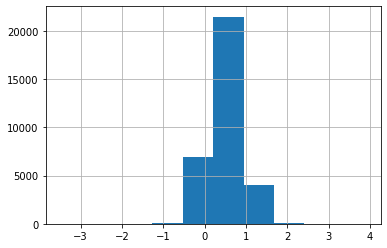

In [14]:
_df['norm_next_close'].hist()

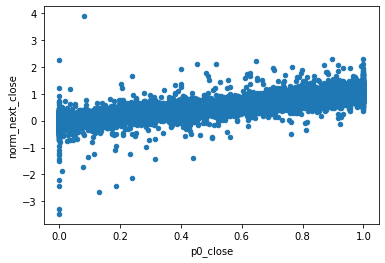

In [15]:
_df.plot(x='p0_close', y='norm_next_close', kind='scatter')

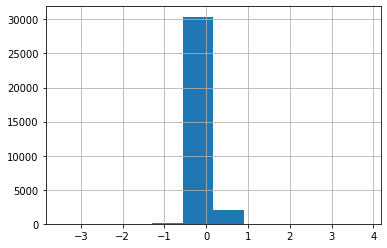

In [16]:
(_df['norm_next_close'] - _df['p0_close']).hist()

In [17]:
(_df['norm_next_close'] - _df['p0_close']).describe()

count    32565.000000
mean         0.001207
std          0.142018
min         -3.476744
25%         -0.056950
50%          0.001366
75%          0.060297
max          3.803987
dtype: float64

### Standardize Close of Individual Window

In [18]:
class StandardizeCloseWindowScaler:
    def fit(self, signal_df):
        self.mean = get_by_signal(signal_df, 'close').mean(axis=1)
        self.std = get_by_signal(signal_df, 'close').std(axis=1)
    def transform(self, signal_df):
        signal_df = signal_df.subtract(self.mean, axis=0).div(self.std, axis=0)
        return signal_df
    def fit_transform(self, signal_df):
        self.fit(signal_df)
        return self.transform(signal_df)
    def transform_target(self, target):
        return (target - self.mean) / self.std
    def inverse_transform_target(self, target):
        return target * self.std + self.mean


In [19]:
_df = df.copy()
signal_df = get_only_signal(_df)

standardize_close_window_scaler = StandardizeCloseWindowScaler()
_df[signal_df.columns] = standardize_close_window_scaler.fit_transform(signal_df)
_df['norm_next_close'] = standardize_close_window_scaler.transform_target(_df['next_close'])
_df

,base_volume,quote_volume,close,high,low,open,next_close,p0_open,p0_high,p0_low,...,p45_close,p46_open,p46_high,p46_low,p46_close,p47_open,p47_high,p47_low,p47_close,norm_next_close
time,,,,,,,,,,,,,,,,,,,,,
2017-08-19 03:00:00,66.65000,1.964252e+04,293.22,299.84,292.83,299.84,291.87,-0.457900,-0.457900,-1.611496,...,0.009462,-0.166621,0.108201,-0.431570,0.078579,57.616839,57.616839,-0.760698,-0.301564,-1.769478
2017-08-19 04:00:00,42.99000,1.263183e+04,291.87,297.19,291.87,293.22,293.23,-1.470599,-0.837151,-1.686003,...,0.881295,0.105841,0.319649,-0.085630,0.038826,-0.131902,0.134561,-0.388791,0.105841,-1.469003
2017-08-19 05:00:00,35.01000,1.040870e+04,293.23,299.90,291.87,291.87,289.02,-1.617535,-0.363915,-1.617535,...,0.997425,0.070090,0.894388,0.057601,0.894388,0.135659,0.344856,-0.051681,0.070090,-2.062468
2017-08-19 06:00:00,45.02000,1.316110e+04,289.02,295.56,289.02,293.23,290.16,-1.304364,-0.955694,-1.934365,...,1.205163,0.899889,1.200673,0.756231,0.998654,0.109770,0.899889,0.097798,0.899889,-1.763771
2017-08-19 07:00:00,112.26000,3.248597e+04,290.16,292.17,287.01,289.02,288.40,-1.837257,-1.376319,-2.131379,...,1.130303,1.030799,1.525392,1.030799,1.232734,0.934222,1.228344,0.793745,1.030799,-1.927981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 19:00:00,22844.22755,8.026408e+07,3512.59,3533.76,3498.28,3525.90,3497.20,1.122488,1.310846,0.460600,...,1.014650,-0.479272,-0.305293,-1.415309,-1.262898,0.034518,0.139481,-1.601031,-0.473041,0.434719
2021-05-07 20:00:00,18632.39404,6.533341e+07,3497.20,3525.62,3476.04,3512.59,3475.89,0.785048,1.097473,-0.091324,...,1.064864,-1.282518,1.373453,-1.290671,0.996289,-0.498459,-0.324384,-1.435014,-1.282518,-0.094920
2021-05-07 21:00:00,21439.49414,7.456822e+07,3475.89,3497.80,3455.70,3497.17,3443.00,0.397685,0.413065,-0.614753,...,-0.127699,0.980197,1.671350,0.322490,1.059053,-1.331053,1.373258,-1.339353,0.989230,-0.924808


/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


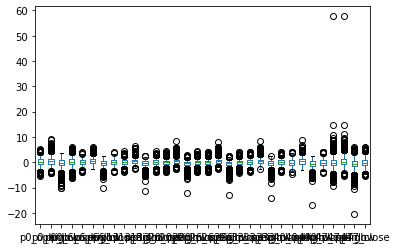

In [20]:
sampled_lookback_steps = np.linspace(0, max(lookback_steps), 8).astype(int)

get_by_lookback_steps(_df, sampled_lookback_steps).plot.box()

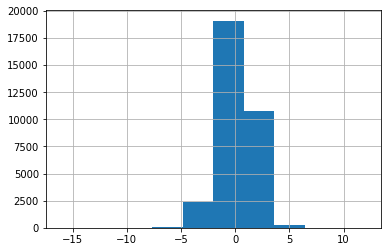

In [21]:
_df['norm_next_close'].hist()

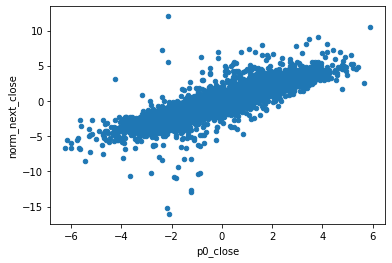

In [22]:
_df.plot(x='p0_close', y='norm_next_close', kind='scatter')

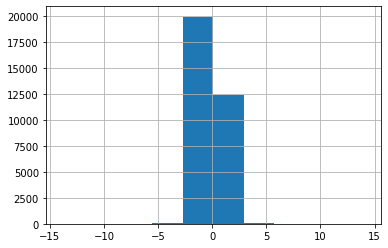

In [23]:
(_df['norm_next_close'] - _df['p0_close']).hist()

In [24]:
(_df['norm_next_close'] - _df['p0_close']).describe()

count    32565.000000
mean         0.004132
std          0.574519
min        -13.962827
25%         -0.217625
50%          0.005067
75%          0.228438
max         14.156852
dtype: float64

### Standardized Window Normalization 

In [25]:
class StandardizeWindowScaler:
    def fit(self, signal_df):
        signal_df = get_only_signal(df)
        means = {}
        stds = {}
        for column in ORIGINAL_SIGNAL_COLUMNS:
            means[column] = get_by_signal(df, column).mean(axis=1)
            stds[column] = get_by_signal(df, column).std(axis=1)
        self.means = pd.DataFrame(means)
        self.stds = pd.DataFrame(stds)
    def transform(self, signal_df):
        signal_df = signal_df.copy()
        for column in ORIGINAL_SIGNAL_COLUMNS:
            signal_column_df = get_by_signal(signal_df, column)
            signal_column_df = signal_column_df.subtract(self.means[column].to_numpy(), axis=0)
            signal_column_df = signal_column_df.divide(self.stds[column].to_numpy(), axis=0)
            signal_df[signal_column_df.columns] = signal_column_df.values
        return signal_df
    def fit_transform(self, signal_df):
        self.fit(signal_df)
        return self.transform(signal_df)
    def transform_target(self, target):
        return (target - self.means['close']) / self.stds['close']
    def inverse_transform_target(self, target):
        return target * self.stds['close'] + self.means['close']


In [26]:
_df = df.copy()
signal_df = get_only_signal(_df)

standardize_window_scaler = StandardizeWindowScaler()
_df[signal_df.columns] = standardize_window_scaler.fit_transform(signal_df)
_df['norm_next_close'] = standardize_window_scaler.transform_target(_df['next_close'])
_df

,base_volume,quote_volume,close,high,low,open,next_close,p0_open,p0_high,p0_low,...,p45_close,p46_open,p46_high,p46_low,p46_close,p47_open,p47_high,p47_low,p47_close,norm_next_close
time,,,,,,,,,,,,,,,,,,,,,
2017-08-19 03:00:00,66.65000,1.964252e+04,293.22,299.84,292.83,299.84,291.87,-0.198669,-0.255710,-1.046979,...,0.009462,-0.163872,-0.187514,0.073445,0.078579,6.739092,6.740330,-0.239086,-0.301564,-1.769478
2017-08-19 04:00:00,42.99000,1.263183e+04,291.87,297.19,291.87,293.22,293.23,-1.541530,-1.396370,-1.160410,...,0.881295,0.107553,-0.152897,0.384792,0.038826,-0.141144,-0.351853,0.092082,0.105841,-1.469003
2017-08-19 05:00:00,35.01000,1.040870e+04,293.23,299.90,291.87,291.87,289.02,-1.679412,-0.912365,-1.118885,...,0.997425,0.069115,0.459320,0.511669,0.894388,0.137050,-0.139728,0.405296,0.070090,-2.062468
2017-08-19 06:00:00,45.02000,1.316110e+04,289.02,295.56,289.02,293.23,290.16,-1.395935,-1.575533,-1.477560,...,1.205163,0.936143,0.810273,1.193897,0.998654,0.100204,0.477486,0.540148,0.899889,-1.763771
2017-08-19 07:00:00,112.26000,3.248597e+04,290.16,292.17,287.01,289.02,288.40,-1.933912,-1.995189,-1.679488,...,1.130303,1.040754,1.150580,1.441267,1.232734,0.940586,0.828547,1.207319,1.030799,-1.927981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 19:00:00,22844.22755,8.026408e+07,3512.59,3533.76,3498.28,3525.90,3497.20,1.146306,0.640054,1.154664,...,1.014650,-0.465794,-0.871742,-0.635231,-1.262898,0.051313,-0.455684,-0.812437,-0.473041,0.434719
2021-05-07 20:00:00,18632.39404,6.533341e+07,3497.20,3525.62,3476.04,3512.59,3475.89,0.803488,0.438627,0.617641,...,1.064864,-1.261696,0.696689,-0.529588,0.996289,-0.478540,-0.890917,-0.667659,-1.282518,-0.094920
2021-05-07 21:00:00,21439.49414,7.456822e+07,3475.89,3497.80,3455.70,3497.17,3443.00,0.415424,-0.201476,0.134704,...,-0.127699,0.987216,0.963665,1.019315,1.059053,-1.281500,0.687639,-0.549205,0.989230,-0.924808


### Apply normalization

In [27]:
scaler = StandardizeWindowScaler()

signal_df = get_only_signal(df)
signal_columns = list(signal_df.columns)
df[signal_df.columns] = scaler.fit_transform(signal_df)
df['norm_next_close'] = scaler.transform_target(df['next_close'])
df

,base_volume,quote_volume,close,high,low,open,next_close,p0_open,p0_high,p0_low,...,p45_close,p46_open,p46_high,p46_low,p46_close,p47_open,p47_high,p47_low,p47_close,norm_next_close
time,,,,,,,,,,,,,,,,,,,,,
2017-08-19 03:00:00,66.65000,1.964252e+04,293.22,299.84,292.83,299.84,291.87,-0.198669,-0.255710,-1.046979,...,0.009462,-0.163872,-0.187514,0.073445,0.078579,6.739092,6.740330,-0.239086,-0.301564,-1.769478
2017-08-19 04:00:00,42.99000,1.263183e+04,291.87,297.19,291.87,293.22,293.23,-1.541530,-1.396370,-1.160410,...,0.881295,0.107553,-0.152897,0.384792,0.038826,-0.141144,-0.351853,0.092082,0.105841,-1.469003
2017-08-19 05:00:00,35.01000,1.040870e+04,293.23,299.90,291.87,291.87,289.02,-1.679412,-0.912365,-1.118885,...,0.997425,0.069115,0.459320,0.511669,0.894388,0.137050,-0.139728,0.405296,0.070090,-2.062468
2017-08-19 06:00:00,45.02000,1.316110e+04,289.02,295.56,289.02,293.23,290.16,-1.395935,-1.575533,-1.477560,...,1.205163,0.936143,0.810273,1.193897,0.998654,0.100204,0.477486,0.540148,0.899889,-1.763771
2017-08-19 07:00:00,112.26000,3.248597e+04,290.16,292.17,287.01,289.02,288.40,-1.933912,-1.995189,-1.679488,...,1.130303,1.040754,1.150580,1.441267,1.232734,0.940586,0.828547,1.207319,1.030799,-1.927981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 19:00:00,22844.22755,8.026408e+07,3512.59,3533.76,3498.28,3525.90,3497.20,1.146306,0.640054,1.154664,...,1.014650,-0.465794,-0.871742,-0.635231,-1.262898,0.051313,-0.455684,-0.812437,-0.473041,0.434719
2021-05-07 20:00:00,18632.39404,6.533341e+07,3497.20,3525.62,3476.04,3512.59,3475.89,0.803488,0.438627,0.617641,...,1.064864,-1.261696,0.696689,-0.529588,0.996289,-0.478540,-0.890917,-0.667659,-1.282518,-0.094920
2021-05-07 21:00:00,21439.49414,7.456822e+07,3475.89,3497.80,3455.70,3497.17,3443.00,0.415424,-0.201476,0.134704,...,-0.127699,0.987216,0.963665,1.019315,1.059053,-1.281500,0.687639,-0.549205,0.989230,-0.924808


## Select input / target columns

In [28]:
selected_columns = []
selected_columns += signal_columns
selected_columns

['p0_open',
 'p0_high',
 'p0_low',
 'p0_close',
 'p1_open',
 'p1_high',
 'p1_low',
 'p1_close',
 'p2_open',
 'p2_high',
 'p2_low',
 'p2_close',
 'p3_open',
 'p3_high',
 'p3_low',
 'p3_close',
 'p4_open',
 'p4_high',
 'p4_low',
 'p4_close',
 'p5_open',
 'p5_high',
 'p5_low',
 'p5_close',
 'p6_open',
 'p6_high',
 'p6_low',
 'p6_close',
 'p7_open',
 'p7_high',
 'p7_low',
 'p7_close',
 'p8_open',
 'p8_high',
 'p8_low',
 'p8_close',
 'p9_open',
 'p9_high',
 'p9_low',
 'p9_close',
 'p10_open',
 'p10_high',
 'p10_low',
 'p10_close',
 'p11_open',
 'p11_high',
 'p11_low',
 'p11_close',
 'p12_open',
 'p12_high',
 'p12_low',
 'p12_close',
 'p13_open',
 'p13_high',
 'p13_low',
 'p13_close',
 'p14_open',
 'p14_high',
 'p14_low',
 'p14_close',
 'p15_open',
 'p15_high',
 'p15_low',
 'p15_close',
 'p16_open',
 'p16_high',
 'p16_low',
 'p16_close',
 'p17_open',
 'p17_high',
 'p17_low',
 'p17_close',
 'p18_open',
 'p18_high',
 'p18_low',
 'p18_close',
 'p19_open',
 'p19_high',
 'p19_low',
 'p19_close',


In [29]:
target_column = 'norm_next_close'
target_column

'norm_next_close'

# Train validation test split

In [30]:
train_df = df.loc[: '2020-11-01']
val_df = df.loc['2020-11-01': '2021-02-01']
test_df = df.loc['2021-02-01': ]
print('train', len(train_df))
print('val', len(val_df))
print('test', len(test_df))

train 28096
val 2224
test 2293


# Model building

In [31]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [32]:
def post_process(y):
    y = scaler.inverse_transform_target(y)
    return y

In [33]:
model = lgb.LGBMRegressor(max_depth=8,
                          boosting_type='goss',
                          learning_rate=0.025,
                          num_leaves=100,
                          n_estimators=64,
                          bagging_fraction=0.8,
                          sub_feature=0.8,
                          metric='mse',
                          feature_fraction_seed=41,
                          bagging_seed=42
                          )
model.fit(train_df[selected_columns], train_df[target_column],
          eval_metric='rmse',
          eval_names=['train', 'val'],
          eval_set=[(train_df[selected_columns], train_df[target_column]),
                    (val_df[selected_columns], val_df[target_column])],
          verbose=True,
          sample_weight=np.linspace(50, 100, len(train_df)),
          early_stopping_rounds=30
          )

[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[1]	train's rmse: 1.49734	train's l2: 2.24201	val's rmse: 1.44911	val's l2: 2.09992
Training until validation scores don't improve for 30 rounds
[2]	train's rmse: 1.46533	train's l2: 2.1472	val's rmse: 1.41723	val's l2: 2.00853
[3]	train's rmse: 1.43424	train's l2: 2.05705	val's rmse: 1.38622	val's l2: 1.92161
[4]	train's rmse: 1.40405	train's l2: 1.97137	val's rmse: 1.35614	val's l2: 1.83912
[5]	train's rmse: 1.37545	train's l2: 1.89187	val's rmse: 1.32797	val's l2: 1.7635
[6]	train's rmse: 1.34692	train's l2: 1.81419	val's rmse: 1.29978	val's l2: 1.68944
[7]	train's rmse: 1.31922	train's l2: 1.74033	val's rmse: 1.2724	val's l2: 1.619
[8]	train's rmse: 1.29231	train's l2: 1.67006	val's rmse: 1.24578	val's l2: 1.55198
[9]	train's rm

LGBMRegressor(bagging_fraction=0.8, bagging_seed=42, boosting_type='goss',
              feature_fraction_seed=41, learning_rate=0.025, max_depth=8,
              metric='mse', n_estimators=64, num_leaves=100, sub_feature=0.8)

In [34]:

prediction = model.predict(df[selected_columns])
df['norm_prediction'] = prediction
df['prediction'] = post_process(prediction)
df

,base_volume,quote_volume,close,high,low,open,next_close,p0_open,p0_high,p0_low,...,p46_high,p46_low,p46_close,p47_open,p47_high,p47_low,p47_close,norm_next_close,norm_prediction,prediction
time,,,,,,,,,,,,,,,,,,,,,
2017-08-19 03:00:00,66.65000,1.964252e+04,293.22,299.84,292.83,299.84,291.87,-0.198669,-0.255710,-1.046979,...,-0.187514,0.073445,0.078579,6.739092,6.740330,-0.239086,-0.301564,-1.769478,-1.193478,295.370147
2017-08-19 04:00:00,42.99000,1.263183e+04,291.87,297.19,291.87,293.22,293.23,-1.541530,-1.396370,-1.160410,...,-0.152897,0.384792,0.038826,-0.141144,-0.351853,0.092082,0.105841,-1.469003,-1.299384,294.293052
2017-08-19 05:00:00,35.01000,1.040870e+04,293.23,299.90,291.87,291.87,289.02,-1.679412,-0.912365,-1.118885,...,0.459320,0.511669,0.894388,0.137050,-0.139728,0.405296,0.070090,-2.062468,-1.082003,295.300319
2017-08-19 06:00:00,45.02000,1.316110e+04,289.02,295.56,289.02,293.23,290.16,-1.395935,-1.575533,-1.477560,...,0.810273,1.193897,0.998654,0.100204,0.477486,0.540148,0.899889,-1.763771,-1.514358,291.826708
2017-08-19 07:00:00,112.26000,3.248597e+04,290.16,292.17,287.01,289.02,288.40,-1.933912,-1.995189,-1.679488,...,1.150580,1.441267,1.232734,0.940586,0.828547,1.207319,1.030799,-1.927981,-1.426353,291.828075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 19:00:00,22844.22755,8.026408e+07,3512.59,3533.76,3498.28,3525.90,3497.20,1.146306,0.640054,1.154664,...,-0.871742,-0.635231,-1.262898,0.051313,-0.455684,-0.812437,-0.473041,0.434719,0.577594,3503.162063
2021-05-07 20:00:00,18632.39404,6.533341e+07,3497.20,3525.62,3476.04,3512.59,3475.89,0.803488,0.438627,0.617641,...,0.696689,-0.529588,0.996289,-0.478540,-0.890917,-0.667659,-1.282518,-0.094920,0.423351,3497.505043
2021-05-07 21:00:00,21439.49414,7.456822e+07,3475.89,3497.80,3455.70,3497.17,3443.00,0.415424,-0.201476,0.134704,...,0.963665,1.019315,1.059053,-1.281500,0.687639,-0.549205,0.989230,-0.924808,-0.062418,3478.323968


In [35]:
train_df = df.loc[: '2020-11-01']
val_df = df.loc['2020-11-01': '2021-02-01']
test_df = df.loc['2021-02-01': ]
print('train', len(train_df))
print('val', len(val_df))
print('test', len(test_df))

train 28096
val 2224
test 2293


In [36]:
train_mae = mean_absolute_error(train_df['next_close'], train_df['prediction'])
val_mae = mean_absolute_error(val_df['next_close'], val_df['prediction'])
test_mae = mean_absolute_error(test_df['next_close'], test_df['prediction'])

print('train mae', train_mae)
print('val mae', val_mae)
print('test mae', test_mae)

train mae 3.0766418000397047
val mae 8.908217497643907
test mae 18.859920047166643


In [34]:
train_rmse = mean_squared_error(train_df['next_close'], train_df['prediction'], squared=False)
val_rmse = mean_squared_error(val_df['next_close'], val_df['prediction'], squared=False)
test_rmse = mean_squared_error(test_df['next_close'], test_df['prediction'], squared=False)

print('train rmse', train_rmse)
print('val rmse', val_rmse)
print('test rmse', test_rmse)

train rmse 6.919259844384478
val rmse 15.055030189468821
test rmse 27.086546889280925


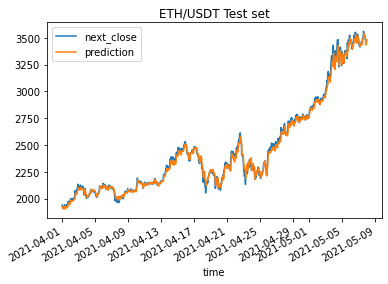

In [37]:
df.loc['2021-04-01':].plot(y=['next_close', 'prediction'], title='ETH/USDT Test set')

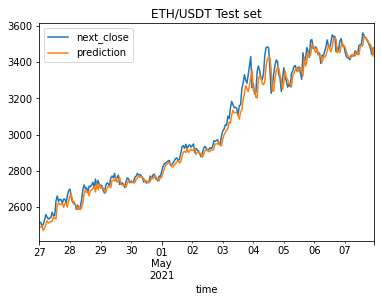

In [38]:
df.loc['2021-04-27':].plot(y=['next_close', 'prediction'], title='ETH/USDT Test set')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

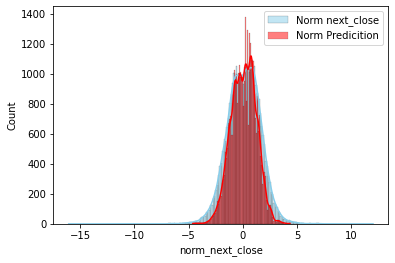

In [39]:
%matplotlib widget
sns.histplot(data=df, x="norm_next_close", color="skyblue", label="Norm next_close", kde=True)
sns.histplot(data=df, x="norm_prediction", color="red", label="Norm Predicition", kde=True)

plt.legend() 
plt.show()

count    32565.000000
mean         0.004132
std          0.574519
min        -13.962827
25%         -0.217625
50%          0.005067
75%          0.228438
max         14.156852
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

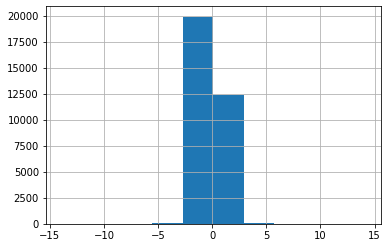

In [40]:
last_close_diff = df['norm_next_close'] - df['p0_close']
print(last_close_diff.describe())
last_close_diff.hist()

count    32565.000000
mean        -0.005957
std          0.271401
min         -2.460282
25%         -0.207629
50%         -0.010602
75%          0.180567
max          2.925441
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

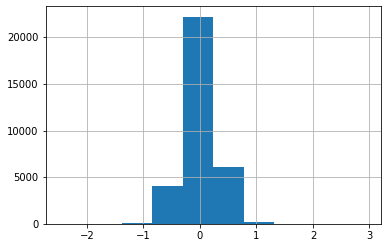

In [41]:
last_close_diff = df['norm_prediction'] - df['p0_close']
print(last_close_diff.describe())
last_close_diff.hist()

In [42]:
%matplotlib widget

sns.histplot(data=df['norm_next_close'] - df['p0_close'], color="skyblue", label="next_close", kde=True)
sns.histplot(data=df['norm_prediction'] - df['p0_close'], color="red", label="predicition", kde=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [43]:
df.plot(x='p0_close', y='norm_prediction', kind='scatter')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [44]:
%matplotlib widget
sns.histplot(data=df, x="next_close", color="skyblue", label="next_close", kde=True)
sns.histplot(data=df, x="prediction", color="red", label="predicition", kde=True)

plt.legend() 
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [45]:
plt.show()

# Export model

In [ ]:
with open('bin/lightgbm_regression_h1-window48.pickle', 'wb') as f:
    pickle.dump(model, f)